# 1. Load packages and data

In [1]:
library(corrplot)
library(data.table)
library(dplyr)
library(extrafont)
library(FactoMineR)
library(ggplot2)
library(ggpubr)
library(gridExtra)
library(Hmisc)
library(hms)
library(httpuv)
library(httr)
library(knitr)
library(kableExtra)
library(lme4)
library(MASS)
library(repr)
library(reshape2)
library(plyr)
library(scales)
library(survival)
library(viridis)
library(rstatix)
library(DescTools) #gmean/gstd
library(tidyr)

corrplot 0.92 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registering fonts with R


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Loading required package: Matrix


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘reshape2’



In [2]:
#read files
filenames <- list.files(path="Data/",pattern="*csv")

#names without extension
names <-sapply(strsplit(filenames, "\\."), `[`, 1)

# load
for(i in names){
    filepath <- file.path("Data/",paste(i,".csv",sep=""))
    assign(i, read.delim(filepath,sep = ","))
}

In [3]:
#sizing in mm based on https://www.elsevier.com/authors/author-schemas/artwork-and-media-instructions/artwork-sizing
min_w=30
single.col_w= 90
half.col_w= 140
max_w= 190
max_h=240

p1<-"transition loops (Phase 1)"
p2<-"transition loops (Phase 2)"
l1<-'Loop_1'
l2<-'Loop_2'
l3<-'Loop_3'
l4<-'Loop_4'
l5<-'Loop_5'
phases <- as.Date(c("10/23/17", "1/5/18"), "%m/%d/%y")

# 2. Data Prep

In [4]:
#set dates
pipe_loops_all_fcm$sample_date<-as.Date(pipe_loops_all_fcm$sample_date)
pipe_loops_all_atp$sample_date<-as.Date(pipe_loops_all_atp$sample_date)
pipe_loops_all_qpcr$sample_date<-as.Date(pipe_loops_all_qpcr$sample_date)
pipe_loops_all$sample_date<-as.Date(pipe_loops_all$sample_date)
pipe_loops_all$batch_sample_date<-as.Date(pipe_loops_all$batch_sample_date)

#subset for plots
pipe_loops_fcm<-pipe_loops_all_fcm[(pipe_loops_all_fcm$broad_location =="Pipe_Loop")|(pipe_loops_all_fcm$adj_loc=='conventional feedwater'),]
notinc<-c('advanced feedwater','conventional feedwater')
loops_only_fcm<-pipe_loops_fcm[!(pipe_loops_fcm$adj_loc %in% notinc),]
PL_feed_fcm<-pipe_loops_fcm[(pipe_loops_fcm$adj_loc %in% notinc),]

pipe_loops<-pipe_loops_all[(pipe_loops_all$broad_location =="Pipe_Loop")|(pipe_loops_all$adj_loc=='conventional feedwater'),]
notinc<-c('advanced feedwater','conventional feedwater')
loops_only<-pipe_loops[!(pipe_loops$adj_loc %in% notinc),]
PL_feed<-pipe_loops[(pipe_loops$adj_loc %in% notinc),]

#set order for plots
pipe_loops_all_fcm$adj_loc<-factor(pipe_loops_all_fcm$adj_loc, levels=(c("full-scale\ndistribution system\n","conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater","RO permeate")))
pipe_loops_fcm$adj_loc<-factor(pipe_loops_fcm$adj_loc, levels=(c("conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater")))
loops_only_fcm$adj_loc<-factor(loops_only_fcm$adj_loc, levels=(c( "conventional control loop", p1, p2,"advanced blend loops")))

pipe_loops_all_atp$adj_loc<-factor(pipe_loops_all_atp$adj_loc, levels=(c("full-scale\ndistribution system\n","conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater","RO permeate")))
pipe_loops_all_qpcr$adj_loc<-factor(pipe_loops_all_qpcr$adj_loc, levels=(c("full-scale\ndistribution system\n","conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater","RO permeate")))

pipe_loops_all$adj_loc<-factor(pipe_loops_all$adj_loc, levels=(c("conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater","RO permeate","full-scale\ndistribution system\n")))
pipe_loops$adj_loc<-factor(pipe_loops$adj_loc, levels=(c("conventional feedwater", "conventional control loop", p1, p2,"advanced blend loops","advanced feedwater")))
loops_only$adj_loc<-factor(loops_only$adj_loc, levels=(c( "conventional control loop", p1, p2,"advanced blend loops")))



# 3. Data analysis

## qPCR prevalence

In [5]:
# above_LoQ_qpcr everything within the range majority rule on triplicates
pipe_loops_all_qpcr$detect<- 0
pipe_loops_all_qpcr[pipe_loops_all_qpcr$non_det_qpcr == 0, "detect"]<- 1

prev_pipe_loops_all_qpcr<-pipe_loops_all_qpcr

prev_pipe_loops_all_qpcr<-pipe_loops_all_qpcr %>% group_by(assay_qpcr, adj_loc, sample_type, influent_composition)  %>%  dplyr::summarize(count=n(), detect=sum(detect), quant=sum(above_LoQ_qpcr)) # sums total counts per assay_qpcr

prev_pipe_loops_all_qpcr$prev<-(prev_pipe_loops_all_qpcr$detect/prev_pipe_loops_all_qpcr$count)*100
minp<-min(prev_pipe_loops_all_qpcr[prev_pipe_loops_all_qpcr$prev>0,"prev"])
prev_pipe_loops_all_qpcr[(prev_pipe_loops_all_qpcr$prev==0 )& (prev_pipe_loops_all_qpcr$count>0 ),"prev"]<-minp/2 #for plotting only


`summarise()` has grouped output by 'assay_qpcr', 'adj_loc', 'sample_type'. You
can override using the `.groups` argument.


In [6]:

c<-prev_pipe_loops_all_qpcr %>% dplyr::group_by(assay_qpcr) %>% dplyr::summarise(total= sum(count),  detect= sum(detect), quant=sum(quant))
c$percent_detect<- round((c$detect/c$total)*100, 0)
c$percent_quant<- round((c$quant/c$total)*100, 0)
c

assay_qpcr,total,detect,quant,percent_detect,percent_quant
<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>
acanthamoeba,79,36,19,46,24
blatem,84,28,15,33,18
legionella,73,1,0,1,0
MAC,68,40,2,59,3
S16,112,112,112,100,100
sul1,84,84,82,100,98


In [7]:
c<-prev_pipe_loops_all_qpcr %>% dplyr::group_by(assay_qpcr, adj_loc) %>% dplyr::summarise(total= sum(count),  detect= sum(detect))
c$percent<- round((c$detect/c$total)*100, 0)
c

`summarise()` has grouped output by 'assay_qpcr'. You can override using the
`.groups` argument.


assay_qpcr,adj_loc,total,detect,percent
<chr>,<fct>,<int>,<dbl>,<dbl>
acanthamoeba,full-scale distribution system,8,2,25
acanthamoeba,conventional feedwater,4,3,75
acanthamoeba,conventional control loop,15,1,7
acanthamoeba,transition loops (Phase 1),9,2,22
acanthamoeba,transition loops (Phase 2),15,8,53
acanthamoeba,advanced blend loops,21,14,67
acanthamoeba,advanced feedwater,7,6,86
blatem,full-scale distribution system,9,1,11
blatem,conventional feedwater,7,1,14


## qPCR sul1

In [8]:
library(stringr)
options(repr.plot.width = 8, repr.plot.height = 8) #change the size of the plot
    # give.n function needs to be formatted to change the "y"
    give.n_b <- function(x){
      return(c(y = -4, label = length(x))) 
      # experiment with the multiplier to find the perfect position
    }


assays<-c("S16", "sul1")

a<- pipe_loops_all_qpcr[pipe_loops_all_qpcr$assay_qpcr %in% assays,]
a[a$assay_qpcr == "S16", "assay_qpcr"]<- "16S rRNA gene"

a<-a[,c("sample_type","GC_per_cm2_avg_qpcr_BLOQ",  "GC_per_mL_avg_qpcr_BLOQ", "assay_qpcr", "adj_loc")]

bf<-a[a$sample_type=="biofilm",]
bf$GC_per_type<-bf$GC_per_cm2_avg_qpcr_BLOQ
bk<-a[a$sample_type=="bulkwater",]
bk$GC_per_type<-bk$GC_per_mL_avg_qpcr_BLOQ

a<-rbind(bf,bk)
a$sample_type<-factor(a$sample_type, levels=c("bulkwater", "biofilm"))

# # BULK WATER
xplot<-ggplot(a, aes(x=adj_loc, y=GC_per_type, fill=assay_qpcr)) + 
    geom_boxplot() +
    stat_summary(fun.data = give.n_b, geom = "text", position = position_dodge(width = 0.75), vjust=0, size=3) +
    scale_fill_manual(name = "qPCR Assay", values=c("#CA3C97", "#F89078"), labels=c("16S rRNA gene", "sul1")) + 
      scale_y_log10(breaks=c(0.01,0.1,1,10, 100,1000,10000,100000,1000000,10000000,100000000),labels = trans_format("log10", math_format(10^.x)))+    
          ylab("Gene concentration\n (copies/mL or copies per square cm)") +
          xlab("") +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 20))+
    facet_wrap(~sample_type, ncol=1)+
    guides(fill=guide_legend(nrow=2, byrow=TRUE))+
    theme(panel.background = element_rect(fill="White", colour = "Black"), 
                axis.text.x = element_text( hjust=1, vjust=0.5,angle = 90, size = 9),
                axis.text.y  = element_text(size = 10),
                axis.title.x = element_text(size=10),
                axis.title.y = element_text(size=10),
                legend.title = element_text(size=8),
                legend.text = element_text(size=8),
                legend.box="vertical", legend.margin=margin(t=-25),
                legend.position= "bottom")


In [9]:
options(repr.plot.width = 8, repr.plot.height = 4) #change the size of the plot

    # give.n function needs to be formatted to change the "y"
    give.n_b <- function(x){
      return(c(y = -6.5, label = length(x))) 
      # experiment with the multiplier to find the perfect position
    }



assays<-c("S16", "sul1")

a<- pipe_loops_all_qpcr[pipe_loops_all_qpcr$assay_qpcr %in% assays,]
a[a$assay_qpcr == "S16", "assay_qpcr"]<- "16S rRNA gene"

a<-a[,c("sample_date","sample_type","GC_per_cm2_avg_qpcr_BLOQ",  "GC_per_mL_avg_qpcr_BLOQ", "assay_qpcr", "adj_loc","influent_composition","location_code_orig")]

bf<-a[a$sample_type=="biofilm",]
bf$GC_per_type<-bf$GC_per_cm2_avg_qpcr_BLOQ
bk<-a[a$sample_type=="bulkwater",]
bk$GC_per_type<-bk$GC_per_mL_avg_qpcr_BLOQ

a<-rbind(bf,bk)
a$sample_type<-factor(a$sample_type, levels=c("bulkwater", "biofilm"))
a<-a[,c("sample_date","sample_type", "adj_loc","assay_qpcr","GC_per_type","influent_composition","location_code_orig")]

c<-reshape(a, idvar = c("sample_date","sample_type", "adj_loc","influent_composition","location_code_orig"), timevar = "assay_qpcr", direction = "wide")

names(c)<- c("sample_date","sample_type", "adj_loc", "influent_composition","location_code_orig","S16","sul1")
c$rel_ab<- c$sul1/c$S16
boxplot_colors=c( "#FDE724", "#20A387","#A2DA38","grey")


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 33 rows containing non-finite values (stat_bin).”



	Kruskal-Wallis rank sum test

data:  rel_ab by adj_loc
Kruskal-Wallis chi-squared = 21.33, df = 3, p-value = 8.992e-05



	Kruskal-Wallis rank sum test

data:  rel_ab by adj_loc
Kruskal-Wallis chi-squared = 30.798, df = 7, p-value = 6.774e-05


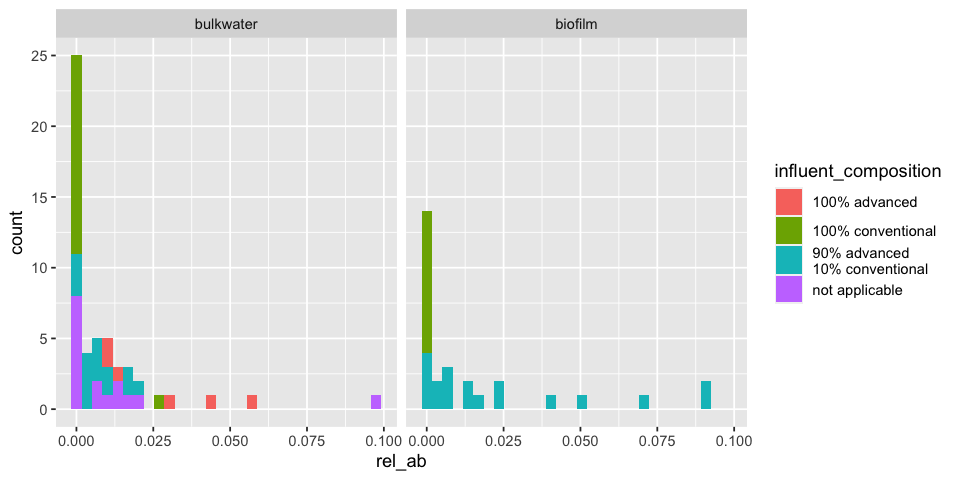

In [10]:
#normally distributed?
# histogram
a <- ggplot(c, aes( x=rel_ab, fill=influent_composition)) +
  geom_histogram() +facet_wrap(~sample_type)

a


#non normal so use kruskall wallis and paired dunn's test
bfm<- c[c$sample_type=="biofilm",]
bk<- c[c$sample_type=="bulkwater",]

kruskal.test(rel_ab ~ adj_loc, data = bfm)
df_bfm<-dunn_test(rel_ab ~ adj_loc, data = bfm)

kruskal.test(rel_ab ~ adj_loc, data = bk)
df_bk<-dunn_test(rel_ab ~ adj_loc, data = bk)

In [11]:
df_bfm_sig<-as.data.frame(df_bfm[df_bfm$p.adj.signif !="ns",])
df_bfm_sig$label<-df_bfm_sig$p.adj.signif
df_bfm_sig$start<-df_bfm_sig$group1
df_bfm_sig$end<-df_bfm_sig$group2
df_bfm_sig<-df_bfm_sig[,c("label","start","end"),]
df_bfm_sig$ypos<-c(8, 7, 6, 5)
df_bfm_sig$sample_type<-"biofilm"

df_bk_sig<-as.data.frame(df_bk[df_bk$p.adj.signif !="ns",])
df_bk_sig$label<-df_bk_sig$p.adj.signif
df_bk_sig$start<-df_bk_sig$group1
df_bk_sig$end<-df_bk_sig$group2
df_bk_sig<-df_bk_sig[,c("label","start","end"),]
df_bk_sig$ypos<-c(8.5, 8, 7.5, 7, 6.5)
df_bk_sig$sample_type<-"bulkwater"

df_sig<-rbind(df_bk_sig,df_bfm_sig)
df_sig$ypos<- df_sig$ypos-5.5

df_sig$ypos

df_sig$sample_type<-factor(df_sig$sample_type, levels=c("bulkwater", "biofilm"))

[1]  3.0  2.5  2.0  1.5  1.0  2.5  1.5  0.5 -0.5

In [12]:
options(repr.plot.width = 8, repr.plot.height = 10) #change the size of the plot

sul1plot<-ggplot(c, aes(x=adj_loc, y=rel_ab)) + 
    geom_boxplot(aes(fill=influent_composition)) +
      scale_fill_manual(values=boxplot_colors) +
      scale_y_log10(breaks=c(0.00001,0.0001,0.001,0.01,0.1,1,10
                            ),labels = trans_format("log10", math_format(10^.x)))+#breaks = c(0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000),
                    # labels = trans_format("log10", math_format(10^.x))) +
      # geom_hline(yintercept=c(0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000), linetype="dashed", color = "grey", size = 0.3) +      
          ylab("sul1\nrelative abundance") +
          xlab("") +
    facet_wrap(~sample_type, ncol=1)+
    labs(fill='Type of\nfeedwater') +
      geom_signif(
    data = df_sig,
    aes(xmin = start, xmax = end, annotations = label, y_position = ypos),
    textsize = 3,
    manual = TRUE
  ) +
    stat_summary(fun.data = give.n_b, geom = "text", position = position_dodge(width = 0.75), vjust=0, size=3) +
    guides(fill=guide_legend(nrow=2, byrow=TRUE))+
    scale_x_discrete(labels = function(x) str_wrap(x, width = 20))+
    theme(panel.background = element_rect(fill="White", colour = "Black"), 
                axis.text.x = element_text(hjust=1, vjust=0.5,angle = 90, size = 9),
                axis.text.y  = element_text(size = 10),
                axis.title.x = element_text(size=10),
                axis.title.y = element_text(size=10),
                legend.title = element_text(size=8),
                legend.text = element_text(size=8),
                legend.box="vertical", legend.margin=margin(t=-25),
                legend.position= "bottom")


Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 33 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 33 rows containing non-finite values (stat_summary).”


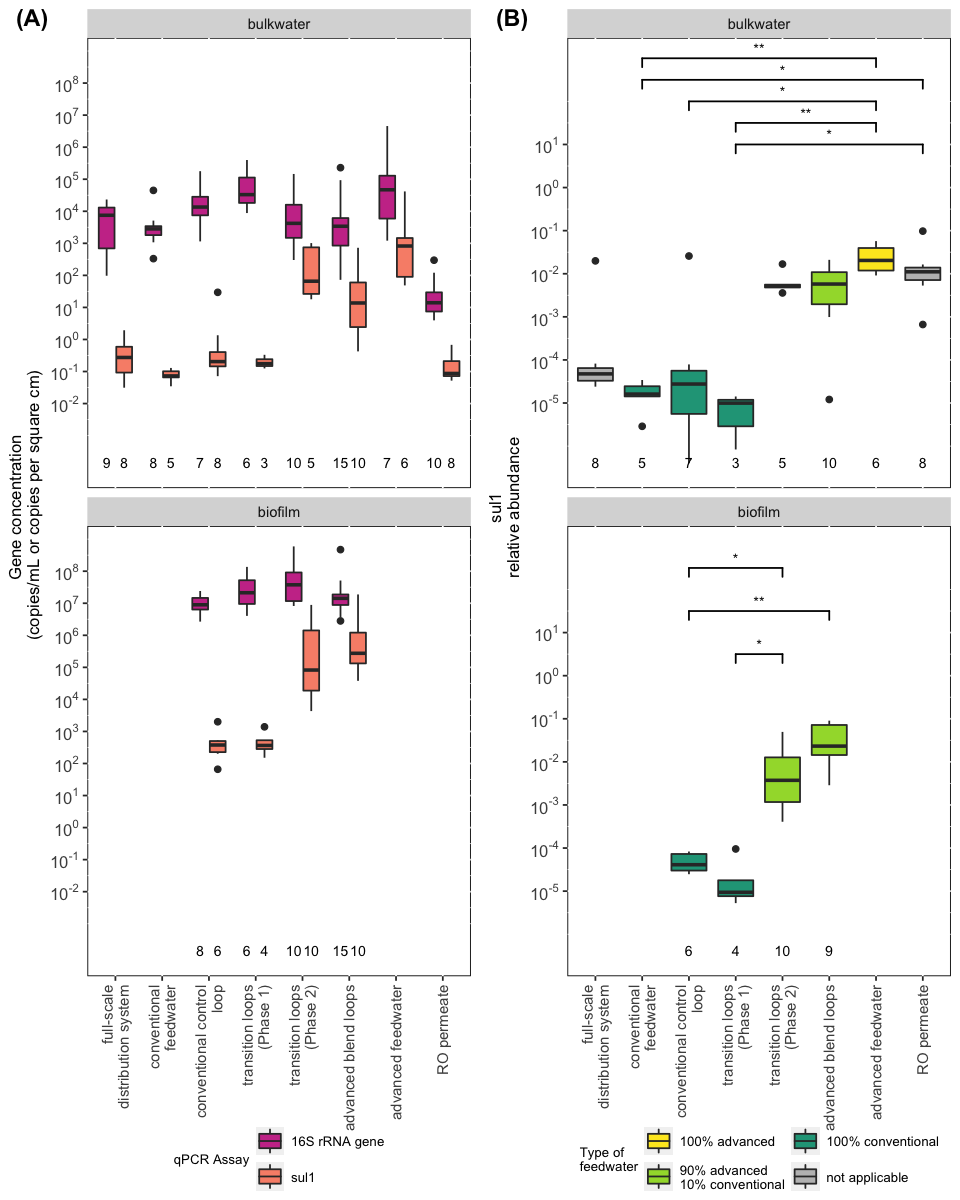

In [13]:
# Arrange plots using ggarrange
fig_sulall <- ggarrange( xplot,sul1plot, labels = c("(A)", "(B)"),
          ncol = 2,
          widths = c(2, 2), heights = c(4, 4))
fig_sulall
ggsave( "Figures/Figure_5.png",  units='mm',device= 'png',width=max_w, height=max_h)

## flow cytometry-based cell counts

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”



	Kruskal-Wallis rank sum test

data:  avg_cells_per_mL_gmean by adj_loc
Kruskal-Wallis chi-squared = 129.86, df = 7, p-value < 2.2e-16



	Kruskal-Wallis rank sum test

data:  avg_cells_per_mL_gmean by adj_loc
Kruskal-Wallis chi-squared = 115.1, df = 7, p-value < 2.2e-16


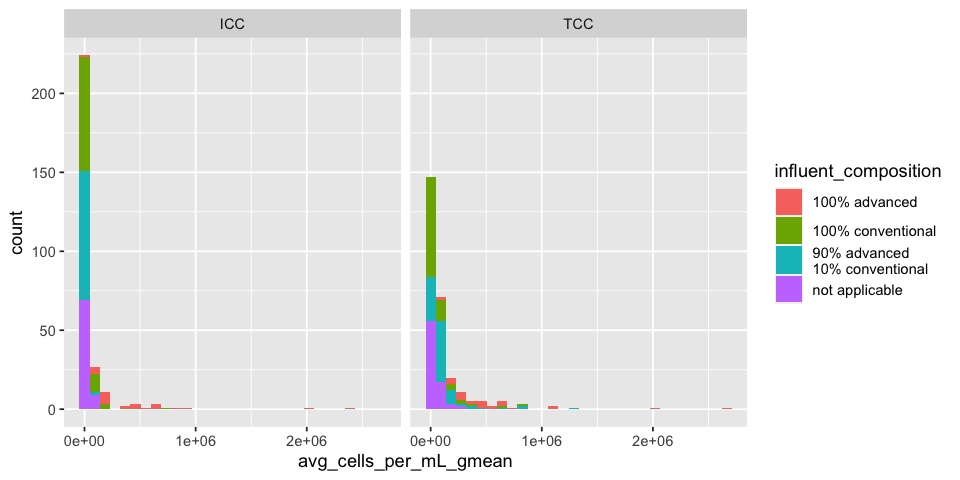

In [14]:
#normally distributed?

options(repr.plot.width = 8, repr.plot.height = 4) #change the size of the plot

b<- pipe_loops_all_fcm[is.na(pipe_loops_all_fcm$batch_end_or_start)|(pipe_loops_all_fcm$batch_end_or_start != "Between_Batch"),]
b<-b[!is.na(b$assay),]

# histogram
a <- ggplot(b, aes( x=avg_cells_per_mL_gmean, fill=influent_composition)) +
  geom_histogram() +facet_wrap(~assay)

a

#non normal so use kruskall wallis and paired dunn's test
SG<- b[b$assay=="TCC",]
PI<-b[b$assay=="ICC",]

kruskal.test(avg_cells_per_mL_gmean ~ adj_loc, data = SG)
df_SG<-dunn_test(avg_cells_per_mL_gmean ~ adj_loc, data = SG)

kruskal.test(avg_cells_per_mL_gmean ~ adj_loc, data = PI)
df_PI<-dunn_test(avg_cells_per_mL_gmean ~ adj_loc, data = PI)

In [15]:
df_SG_sig<-as.data.frame(df_SG[df_SG$p.adj.signif !="ns",])
df_SG_sig$label<-df_SG_sig$p.adj.signif
df_SG_sig$start<-df_SG_sig$group1
df_SG_sig$end<-df_SG_sig$group2
df_SG_sig<-df_SG_sig[,c("label","start","end"),]
df_SG_sig<- df_SG_sig[df_SG_sig$end != "RO permeate",] #everything is significantly different from RO permeate including advanced feedwater
df_SG_sig<- df_SG_sig[df_SG_sig$end != "advanced feedwater",] #everything is significantly different from advanced feedwater including RO perm
df_SG_sig$ypos<-c(8, 7.5, 6.5)

df_PI_sig<-as.data.frame(df_PI[df_PI$p.adj.signif !="ns",])
df_PI_sig$label<-df_PI_sig$p.adj.signif
df_PI_sig$start<-df_PI_sig$group1
df_PI_sig$end<-df_PI_sig$group2
df_PI_sig<-df_PI_sig[,c("label","start","end"),]
df_PI_sig<- df_PI_sig[df_PI_sig$end != "RO permeate",] #everything is significantly different from RO permeate including advanced feedwater
df_PI_sig<- df_PI_sig[df_PI_sig$end != "advanced feedwater",] #everything is significantly different from advanced feedwater including RO perm
df_PI_sig$ypos<-c(8, 7 )

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”
Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”


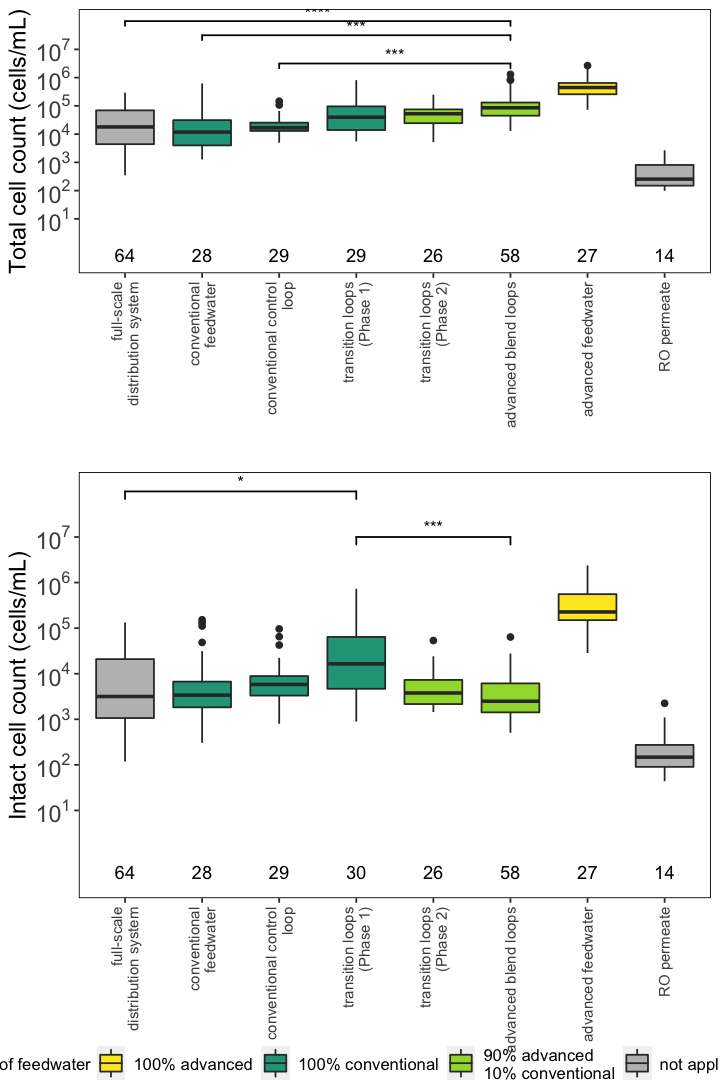

In [16]:
library(ggsignif)

# Plotting characteristics

    # for plotting size in jupyter
    options(repr.plot.width = 6, repr.plot.height = 9) 

    # give.n function needs to be formatted to change the "y"
    give.n_b <- function(x){
      return(c(y = -0.5, label = length(x))) 
      # experiment with the multiplier to find the perfect position
    }

    # Colors for plotting
    boxplot_colors=c( "#FDE724", "#20A387","#A2DA38","grey")


# fill=influent_composition

# TCC plot 

a<-ggplot(SG, aes(x = adj_loc, y = avg_cells_per_mL_gmean)) +
  geom_boxplot(aes(fill=influent_composition)) +
  scale_fill_manual(values=boxplot_colors) +
  ylab("Total cell count (cells/mL)") +
  labs(fill='Type of feedwater') +
  xlab("") + 
  geom_signif(
    data = df_SG_sig,
    aes(xmin = start, xmax = end, annotations = label, y_position = ypos),
    textsize = 3.5,
    manual = TRUE
  ) +
stat_summary(fun.data = give.n_b, geom = "text", position = position_dodge(width = 0.75), vjust=0) +
scale_y_log10(breaks=c(10,100,1000,10000,100000,1000000,10000000),labels = trans_format("log10", math_format(10^.x)))+
scale_x_discrete(labels = function(x) str_wrap(x, width = 20))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        title =element_text(size=14),
        axis.text.x = element_text(hjust=1, vjust=0.5,angle = 90, size = 9),
        axis.text.y = element_text(size = 14),
        axis.title.y=element_text(size=14),
        axis.title.x= element_text(size = 14),
        legend.box.background = element_blank(),
        legend.title = element_text(size=10),
        legend.text = element_text(size=10),
        legend.position="none", legend.margin=margin(t=-25))

                     


# # ICC plot 
b<-ggplot(PI, aes(x = adj_loc, y = avg_cells_per_mL_gmean)) +
  geom_boxplot(aes(fill=influent_composition)) +
  scale_fill_manual(values=boxplot_colors) +
  ylab("Intact cell count (cells/mL)") +
  labs(fill='Type of feedwater') +
  xlab("") + 
  geom_signif(
    data = df_PI_sig,
    aes(xmin = start, xmax = end, annotations = label, y_position = ypos),
    textsize = 3.5,
    manual = TRUE
  ) +
stat_summary(fun.data = give.n_b, geom = "text", position = position_dodge(width = 0.75), vjust=0) +
scale_y_log10(breaks=c(10,100,1000,10000,100000,1000000,10000000),labels = trans_format("log10", math_format(10^.x)))+
scale_x_discrete(labels = function(x) str_wrap(x, width = 20))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        title =element_text(size=14),
        axis.text.x = element_text(hjust=1, vjust=0.5,angle = 90, size = 9),
        axis.text.y = element_text(size = 14),
        axis.title.y=element_text(size=14),
        axis.title.x= element_text(size = 14),
        legend.box.background = element_blank(),
        legend.title = element_text(size=10),
        legend.text = element_text(size=10),
        legend.position="none", legend.margin=margin(t=-25))


icc<-a
tcc<-b
# Arrange plots using ggarrange
fig_totint <- ggarrange(a, b,
          ncol = 1, nrow = 2,
          common.legend=TRUE,legend="bottom",
          widths = c(2, 2), heights = c(4, 5.4))
fig_totint

In [17]:
PI_sum<-PI %>% group_by(adj_loc, sample_type, influent_composition)  %>%  dplyr::summarize(count=n(), mean=mean(avg_cells_per_mL_gmean, na.rm=TRUE))

PI_sum$mean<- format(PI_sum$mean, scientific=TRUE, digits=3)
PI_sum


SG_sum<-SG %>% group_by(adj_loc, sample_type, influent_composition)  %>%  dplyr::summarize(count=n(), mean=mean(avg_cells_per_mL_gmean, na.rm=TRUE))

SG_sum$mean<- format(SG_sum$mean, scientific=TRUE, digits=3)
SG_sum

`summarise()` has grouped output by 'adj_loc', 'sample_type'. You can override
using the `.groups` argument.


adj_loc,sample_type,influent_composition,count,mean
<fct>,<chr>,<chr>,<int>,<chr>
full-scale distribution system,bulkwater_grab,not applicable,64,1.80e+04
conventional feedwater,bulkwater_grab,100% conventional,29,2.02e+04
conventional control loop,bulkwater_grab,100% conventional,29,1.28e+04
transition loops (Phase 1),bulkwater_grab,100% conventional,30,6.09e+04
transition loops (Phase 2),bulkwater_grab,90% advanced 10% conventional,28,7.57e+03
advanced blend loops,bulkwater_grab,90% advanced 10% conventional,58,5.49e+03
advanced feedwater,bulkwater_grab,100% advanced,28,4.72e+05
RO permeate,bulkwater_grab,not applicable,14,4.18e+02


`summarise()` has grouped output by 'adj_loc', 'sample_type'. You can override
using the `.groups` argument.


adj_loc,sample_type,influent_composition,count,mean
<fct>,<chr>,<chr>,<int>,<chr>
full-scale distribution system,bulkwater_grab,not applicable,64,4.51e+04
conventional feedwater,bulkwater_grab,100% conventional,29,6.99e+04
conventional control loop,bulkwater_grab,100% conventional,29,2.68e+04
transition loops (Phase 1),bulkwater_grab,100% conventional,29,8.76e+04
transition loops (Phase 2),bulkwater_grab,90% advanced 10% conventional,28,6.71e+04
advanced blend loops,bulkwater_grab,90% advanced 10% conventional,58,1.52e+05
advanced feedwater,bulkwater_grab,100% advanced,28,5.80e+05
RO permeate,bulkwater_grab,not applicable,14,6.80e+02


Warning message:
“Removed 12 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 12 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


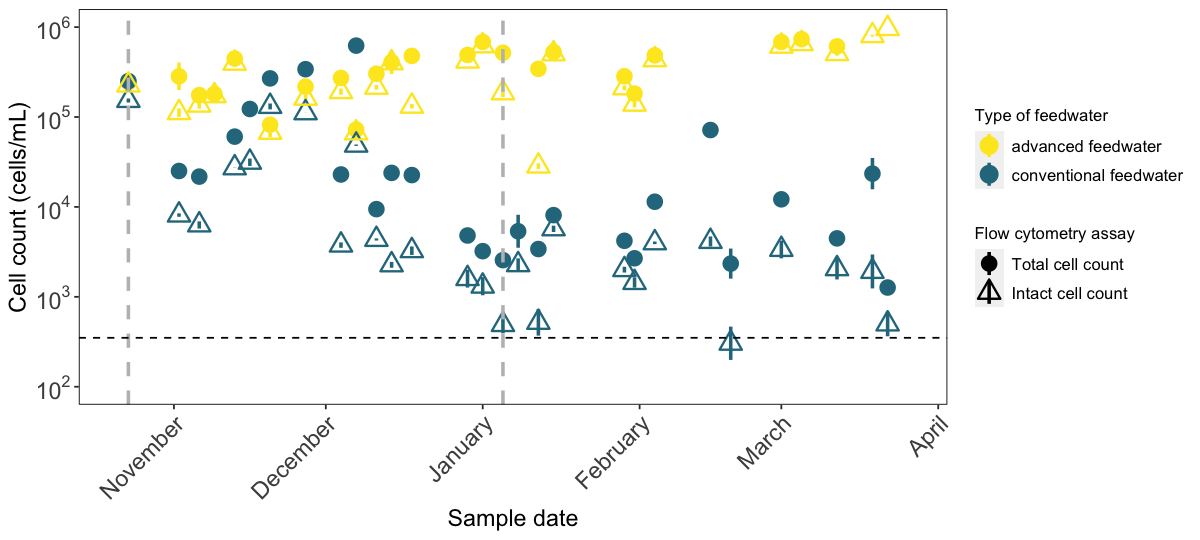

In [18]:
PL_feed_plot <- PL_feed_fcm
PL_feed_plot$assay <- factor(PL_feed_plot$assay, levels=c("TCC", "ICC"))
levels(PL_feed_plot$assay) <- c("Total cell count", "Intact cell count")
feed_colors <- c("#FDE724", "#2A788D")

# Plot
options(repr.plot.width = 10, repr.plot.height = 4.5) #for plotting size in jupyter

min = as.Date("2017-10-21")
max = as.Date("2018-03-26")

ggplot(PL_feed_plot, aes(x=sample_date, y=avg_cells_per_mL_gmean, color=adj_loc, shape=assay))+
    geom_pointrange(aes(ymin=avg_cells_per_mL_gmean/ avg_cells_per_mL_gstd, ymax=avg_cells_per_mL_gmean* avg_cells_per_mL_gstd), size = 1) +
    scale_colour_manual(name = "Type of feedwater", values = feed_colors) +
    scale_shape_manual(values=c(16, 2)) +
        scale_y_log10(limits = c(100, 1000000), labels = trans_format("log10", math_format(10^.x))) +
        scale_x_date(date_labels = "%B", date_breaks = "1 month", limits = c(min=min, max=max)) +
        ylab("Cell count (cells/mL)") +
        xlab("Sample date") +
        labs(color="Feed water", shape="Flow cytometry assay") +
     geom_vline(xintercept = phases, linetype="dashed", color="gray", size=1) + 
    geom_hline(yintercept=350, linetype="dashed", color = "black", size = 0.5) + # Geomean TCC in RO permeate
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        title =element_text(size=14),
        axis.text.x = element_text(hjust = 1, angle = 45, size = 14),
        axis.text.y  = element_text(size = 14),
        axis.title.y = element_text(size=14),
        axis.title.x = element_text(size=14),
        legend.box.background = element_blank(),
        legend.title = element_text(size=10),
        legend.text  = element_text(size=10),
        legend.position="right")


ggsave("Figures/Figure_S2.png",  units='mm',device= 'png',width=max_w, height=max_h/2.5)


## ATP

In [19]:
options(repr.plot.width = 8, repr.plot.height = 4) #change the size of the plot

    # give.n function needs to be formatted to change the "y"
    give.n_b <- function(x){
      return(c(y = -6.5, label = length(x))) 
      # experiment with the multiplier to find the perfect position
    }



a<- pipe_loops_all_atp

a<-a[,c("sample_date","sample_type",'intra_ATP_gmean_nM_MDL','intra_ATP_gstd_nM', 'intra_ATP_gmean_ng_cm2_MDL','intra_ATP_gstd_ng_cm2', "adj_loc","influent_composition","location_code_orig")]

bf<-a[a$sample_type=="biofilm",]
bf$intra_per_type_gmean<-bf$intra_ATP_gmean_ng_cm2_MDL
bf$intra_per_type_gstd<-bf$intra_ATP_gstd_ng_cm2
bk<-a[a$sample_type=="bulkwater",]
bk$intra_per_type_gmean<-bk$intra_ATP_gmean_nM_MDL
bk$intra_per_type_gstd<-bk$intra_ATP_gstd_nM

a<-rbind(bf,bk)
a$sample_type<-factor(a$sample_type, levels=c("bulkwater", "biofilm"))
a<-a[,c("sample_date","sample_type", "adj_loc","intra_per_type_gmean","intra_per_type_gstd","influent_composition","location_code_orig")]

boxplot_colors=c( "#FDE724", "#20A387","#A2DA38","grey")


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 15 rows containing non-finite values (stat_bin).”



	Kruskal-Wallis rank sum test

data:  intra_per_type_gmean by adj_loc
Kruskal-Wallis chi-squared = 8.8689, df = 3, p-value = 0.03109



	Kruskal-Wallis rank sum test

data:  intra_per_type_gmean by adj_loc
Kruskal-Wallis chi-squared = 74.866, df = 7, p-value = 1.527e-13


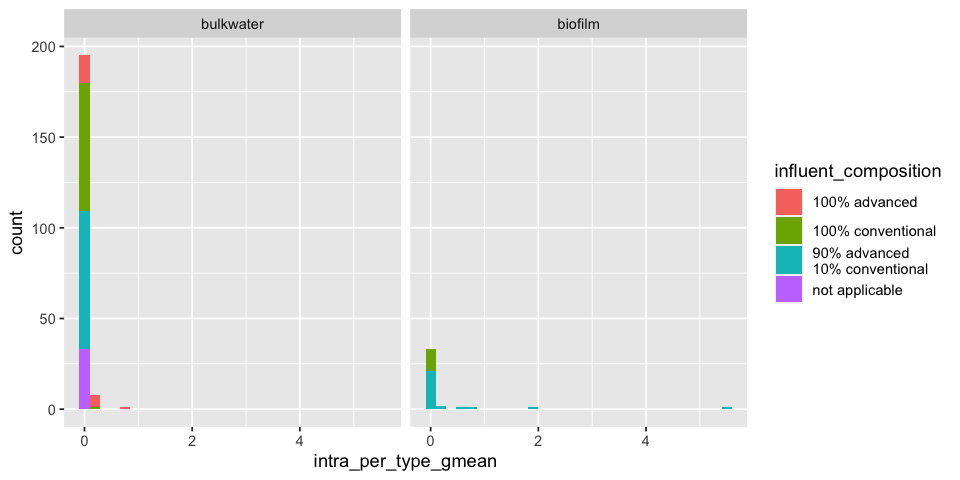

In [20]:
options(repr.plot.width = 8, repr.plot.height = 4) #change the size of the plot
#normally distributed?
# histogram
c <- ggplot(a, aes( x=intra_per_type_gmean, fill=influent_composition)) +
  geom_histogram() +facet_wrap(~sample_type)

c


#non normal so use kruskall wallis and paired dunn's test
bfm<- a[a$sample_type=="biofilm",]
bk<- a[a$sample_type=="bulkwater",]

kruskal.test(intra_per_type_gmean ~ adj_loc, data = bfm)
df_bfm<-dunn_test(intra_per_type_gmean ~ adj_loc, data = bfm)

kruskal.test(intra_per_type_gmean ~ adj_loc, data = bk)
df_bk<-dunn_test(intra_per_type_gmean ~ adj_loc, data = bk)

In [21]:
df_bfm_sig<-as.data.frame(df_bfm[df_bfm$p.adj.signif !="ns",])
df_bfm_sig$label<-df_bfm_sig$p.adj.signif
df_bfm_sig$start<-df_bfm_sig$group1
df_bfm_sig$end<-df_bfm_sig$group2
df_bfm_sig<-df_bfm_sig[,c("label","start","end"),]
df_bfm_sig$ypos<-c(3)
df_bfm_sig$sample_type<-"biofilm"

df_bk_sig<-as.data.frame(df_bk[df_bk$p.adj.signif !="ns",])
df_bk_sig$label<-df_bk_sig$p.adj.signif
df_bk_sig$start<-df_bk_sig$group1
df_bk_sig$end<-df_bk_sig$group2
df_bk_sig<-df_bk_sig[,c("label","start","end"),]
df_bk_sig$ypos<-c(5,4.5,4,3.5,3,2.5,2)
df_bk_sig$sample_type<-"bulkwater"
df_bk_sig

df_sig<-rbind(df_bk_sig,df_bfm_sig)

df_sig$ypos
df_sig$sample_type<-factor(df_sig$sample_type, levels=c("bulkwater", "biofilm"))

label,start,end,ypos,sample_type
<chr>,<chr>,<chr>,<dbl>,<chr>
****,full-scale distribution system,advanced feedwater,5.0,bulkwater
****,conventional feedwater,advanced feedwater,4.5,bulkwater
****,conventional control loop,advanced feedwater,4.0,bulkwater
***,transition loops (Phase 1),advanced feedwater,3.5,bulkwater
***,transition loops (Phase 2),advanced feedwater,3.0,bulkwater
****,advanced blend loops,advanced feedwater,2.5,bulkwater
**,advanced feedwater,RO permeate,2.0,bulkwater


[1] 5.0 4.5 4.0 3.5 3.0 2.5 2.0 3.0

In [22]:
options(repr.plot.width = 8, repr.plot.height = 10) #change the size of the plot

atpplot<-ggplot(a, aes(x=adj_loc, y=intra_per_type_gmean)) + 
    geom_boxplot(aes(fill=influent_composition)) +
      scale_fill_manual(values=boxplot_colors) +
      scale_y_log10(breaks=c(0.00001,0.0001,0.001,0.01,0.1,1,10),labels = trans_format("log10", math_format(10^.x)))+#breaks = c(0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000),     
          ylab("intracellular ATP (nM or ng per square cm)") +
          xlab("") +
    facet_wrap(~sample_type, ncol=1)+
    labs(fill='Type of feedwater') +
    geom_signif(
    data = df_sig,
    aes(xmin = start, xmax = end, annotations = label, y_position = ypos),
    textsize = 3,
    manual = TRUE
  ) +
 scale_x_discrete(labels = function(x) str_wrap(x, width = 20))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        title =element_text(size=14),
        axis.text.x = element_text(hjust=1, vjust=0.5,angle = 90, size = 9),
        axis.text.y = element_text(size = 14),
        axis.title.y=element_text(size=14),
        axis.title.x= element_text(size = 14),
        legend.box.background = element_blank(),
        legend.title = element_text(size=10),
        legend.text = element_text(size=10),
        legend.position="none", legend.margin=margin(t=-25))


Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 15 rows containing non-finite values (stat_boxplot).”


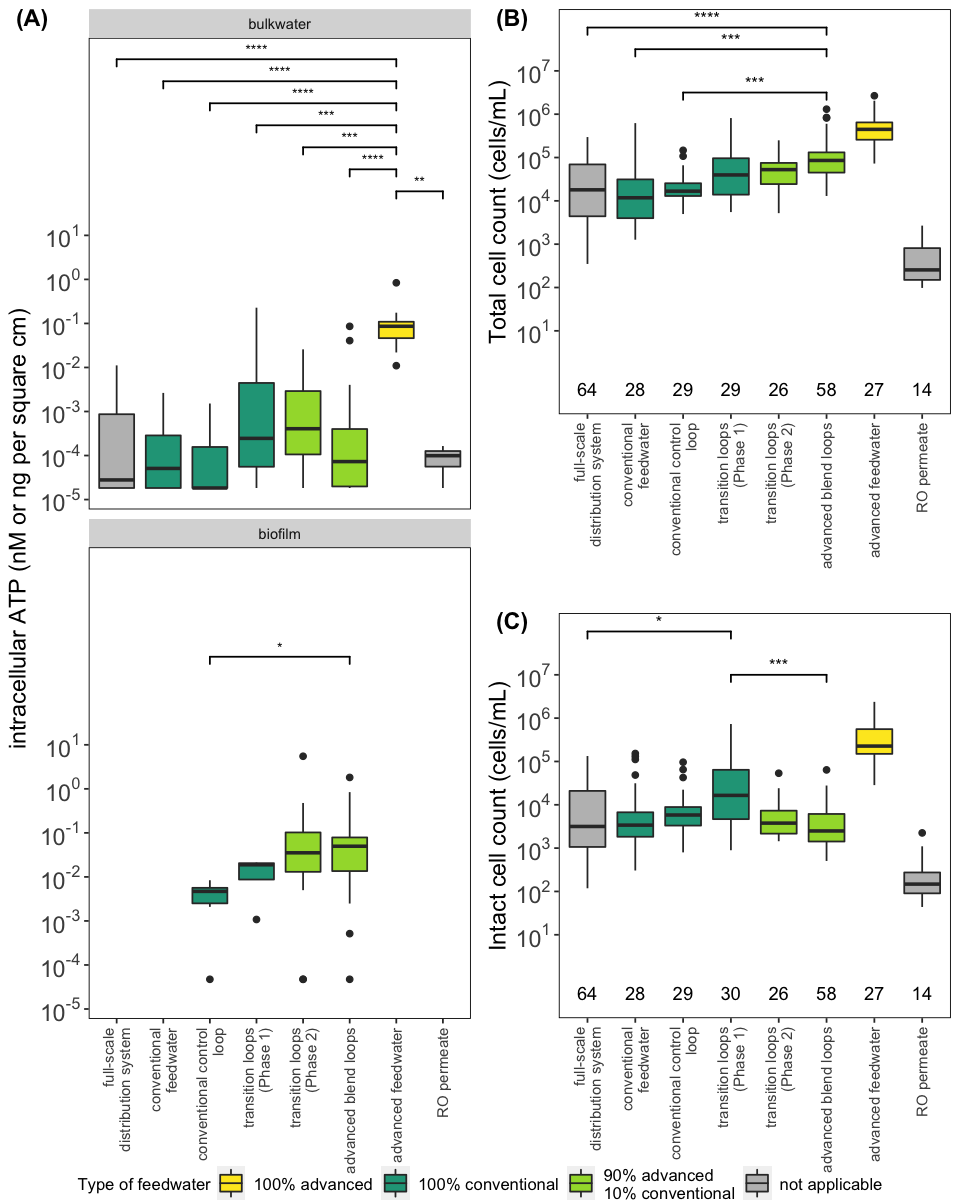

In [23]:
# Arrange plots using ggarrange
g <- ggarrange(atpplot,
    ggarrange(icc,  tcc, ncol= 1, legend="none", labels = c("(B)", "(C)")), labels = c("(A)", ""), 
               common.legend=TRUE, legend='bottom',ncol=2)


g
ggsave( "Figures/Figure_2.png",  units='mm',device= 'png',width=max_w, height=max_h)

## Temperature

In [24]:
give.n <- function(x){
  return(c(y = 0, label = length(x))) 
  # experiment with the multiplier to find the perfect position
}

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 5 rows containing non-finite values (stat_summary).”


[1] 15.90405

Warning message:
“Removed 5 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 5 rows containing non-finite values (stat_summary).”


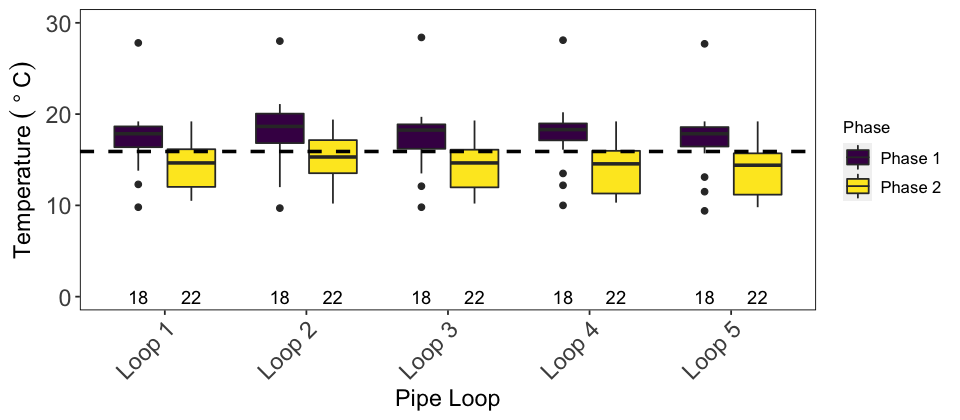

In [25]:

options(repr.plot.width = 8, repr.plot.height = 3.5) #for plotting size in jupyter

d=loops_only
d=d[d$batch_end_or_start=="Batch_End",]
d$location_code_orig<-gsub(l1,"Loop 1",d$location_code_orig)
d$location_code_orig<-gsub(l2,"Loop 2",d$location_code_orig)
d$location_code_orig<-gsub(l3,"Loop 3",d$location_code_orig)
d$location_code_orig<-gsub(l4,"Loop 4",d$location_code_orig)
d$location_code_orig<-gsub(l5,"Loop 5",d$location_code_orig)
d[d$Phase=="Phase 2b","Phase"]<- "Phase 2"
d[d$Phase=="Phase 2a","Phase"]<- "Phase 2"

# # TEMPERATURE
ggplot(d, aes(x=location_code_orig, y=temp_C, fill=Phase))+
        geom_boxplot()+
        geom_hline(yintercept = mean(d$temp_C, na.rm=TRUE), linetype="dashed", color="black", size=1) + 
          scale_shape_manual(values=c(16, 2)) +
            scale_fill_viridis_d()+
            ylim(0,30)+
            xlab("Pipe Loop") +
            ylab(bquote(.("Temperature ")(~degree~"C"))) +
            stat_summary(fun.data = give.n, geom = "text", fun.y = median,
                  position = position_dodge(width = 0.75))+
            #labs(color="Feed Water", shape="Assay") +
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        title =element_text(size=14),
        axis.text.x = element_text(hjust = 1, angle = 45, size = 14),
        axis.text.y  = element_text(size = 14),
        axis.title.y = element_text(size=14),
        axis.title.x = element_text(size=14),
        legend.box.background = element_blank(),
        legend.title = element_text(size=10),
        legend.text  = element_text(size=10),
        legend.position="right")

mean(d$temp_C, na.rm=TRUE)
ggsave("Figures/Figure_S3.png",  units='mm',device= 'png',width=max_w, height=max_h/2.5)



In [26]:
PL_feed_plot <- pipe_loops_all_fcm
PL_feed_plot<-PL_feed_plot[PL_feed_plot$location_code_orig %in%  c("Loop_1","Loop_2","Loop_3","Loop_4","Loop_5"),]
PL_feed_plot <-  subset(PL_feed_plot, PL_feed_plot$ICC_to_TCC < 1.1) #some samples were repeated because they had abnormal ICC to TCC ratios. THis filters those out
PL_feed_plot$location_code_orig<- as.factor(PL_feed_plot$location_code_orig)
levels(PL_feed_plot$location_code_orig) <- c("Loop 1", "Loop 2", "Loop 3", "Loop 4", "Loop 5")


PL_feed_plot$assay <- factor(PL_feed_plot$assay, levels=c("TCC", "ICC"))
levels(PL_feed_plot$assay) <- c("Total cell count", "Intact cell count")
feed_colors <- c("#FDE724", "#2A788D")

# Plot
options(repr.plot.width = 8, repr.plot.height = 10) #for plotting size in jupyter

min = as.Date("2017-10-21")
max = as.Date("2018-03-26")

a<-ggplot(PL_feed_plot, aes(x=sample_date, y=avg_cells_per_mL_gmean, color=influent_composition,  shape=assay))+
    geom_pointrange(aes(ymin=avg_cells_per_mL_gmean/ avg_cells_per_mL_gstd, ymax=avg_cells_per_mL_gmean* avg_cells_per_mL_gstd), size = 0.7) +
    scale_colour_manual(name = "Type of feedwater", values = c("#2A788D", "#A2DA38")) +
    scale_shape_manual(values=c(16, 2)) +
        scale_y_log10(limits = c(100, 1000000), labels = trans_format("log10", math_format(10^.x))) +
        scale_x_date(date_labels = "%B", date_breaks = "1 month", limits = c(min=min, max=max)) +
        ylab("Cell count (cells/mL)") +
        xlab("Sample date") +
        labs(color="Feed water", shape="Flow cytometry assay") +
     geom_vline(xintercept = phases, linetype="dashed",  color="gray60", size=1) + 
    geom_hline(yintercept=350, linetype="dashed", color = "black", size = 0.5) + # Geomean TCC in RO permeate
    facet_wrap(~location_code_orig, ncol=1)+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        title =element_text(size=14),
        axis.text.x = element_text(hjust = 1, angle = 45, size = 14),
        axis.text.y  = element_text(size = 14),
        axis.title.y = element_text(size=14),
        axis.title.x = element_text(size=14),
        legend.box.background = element_blank(),
        legend.title = element_text(size=8),
        legend.text  = element_text(size=8),
        legend.direction = "vertical",
        legend.position="bottom")



## Chlorine

In [27]:
cl_plot <- loops_only
cl_plot$location_code<-cl_plot$location_code_orig

# Batch end and start
cl_plot=cl_plot[cl_plot$batch_end_or_start!="Between_Batch",]
cl_plot$batch_end_or_start<- factor(cl_plot$batch_end_or_start, levels=c("Batch_Start", "Batch_End"))
levels(cl_plot$batch_end_or_start) <- c("Start of batch period", "End of batch period" )   
colors_batch <- c("#2A788D", "#A2DA38", "black", "black")

cl_plot$cl2y=0.02
cl_plot$Limit="<0.02 mg/L total chlorine"

### PLOT
options(repr.plot.width = 8, repr.plot.height = 10) #for plotting size in jupyter

cl_plot$totalCl2_sub<-cl_plot$total_Cl2_mg.L
cl_plot[!is.na(cl_plot$total_Cl2_mg.L)&(cl_plot$total_Cl2_mg.L <=  0.02), "totalCl2_sub"]<- -0.25

b<-ggplot()+
    facet_wrap(~location_code, ncol=1) +
        geom_point(data=cl_plot, aes(x=batch_sample_date, y=totalCl2_sub, shape=batch_end_or_start, color=influent_composition),size=3) + 
        geom_vline(xintercept=phases, linetype="dashed", color="gray60", size=1)+ 
        geom_hline(yintercept=0.02, linetype="dashed", color = "black", size = 0.5) +
            ylab("Total chlorine concentration (mg/L)") +
            xlab("Sample date") +
            scale_x_date(date_labels = "%B", date_breaks = "1 month", limits = c(min=min, max=max)) +
            scale_y_continuous(limits = c(-0.5, 3), expand= c(0,0))+
    scale_colour_manual(name = "Type of feedwater", values = c("#2A788D", "#A2DA38")) +
    scale_shape_manual(name = "Start or end\nof batch period",labels = c("Start of batch period","End of batch period"),values=c(16, 2)) +
        scale_linetype_manual(name = "", values = c("longdash", "solid", "dashed"),guide=FALSE) +
            annotate("rect", xmin = min, xmax =max, ymin = -0.5, ymax = 0.02, alpha = .2, 
             fill="red", label="<0.02 mg/L total chlorine")+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        title =element_text(size=14),
        axis.text.x = element_text(hjust = 1, angle = 45, size = 14),
        axis.text.y  = element_text(size = 14),
        axis.title.y = element_text(size=14),
        axis.title.x = element_text(size=14),
        legend.box.background = element_blank(),
        legend.title = element_text(size=8),
        legend.text  = element_text(size=8),
        legend.direction = "vertical",
        legend.position="bottom")+
    guides(colour = guide_legend( ncol = 1))



Warning message:
“Ignoring unknown parameters: label”


Warning message:
“Removed 11 rows containing missing values (geom_point).”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


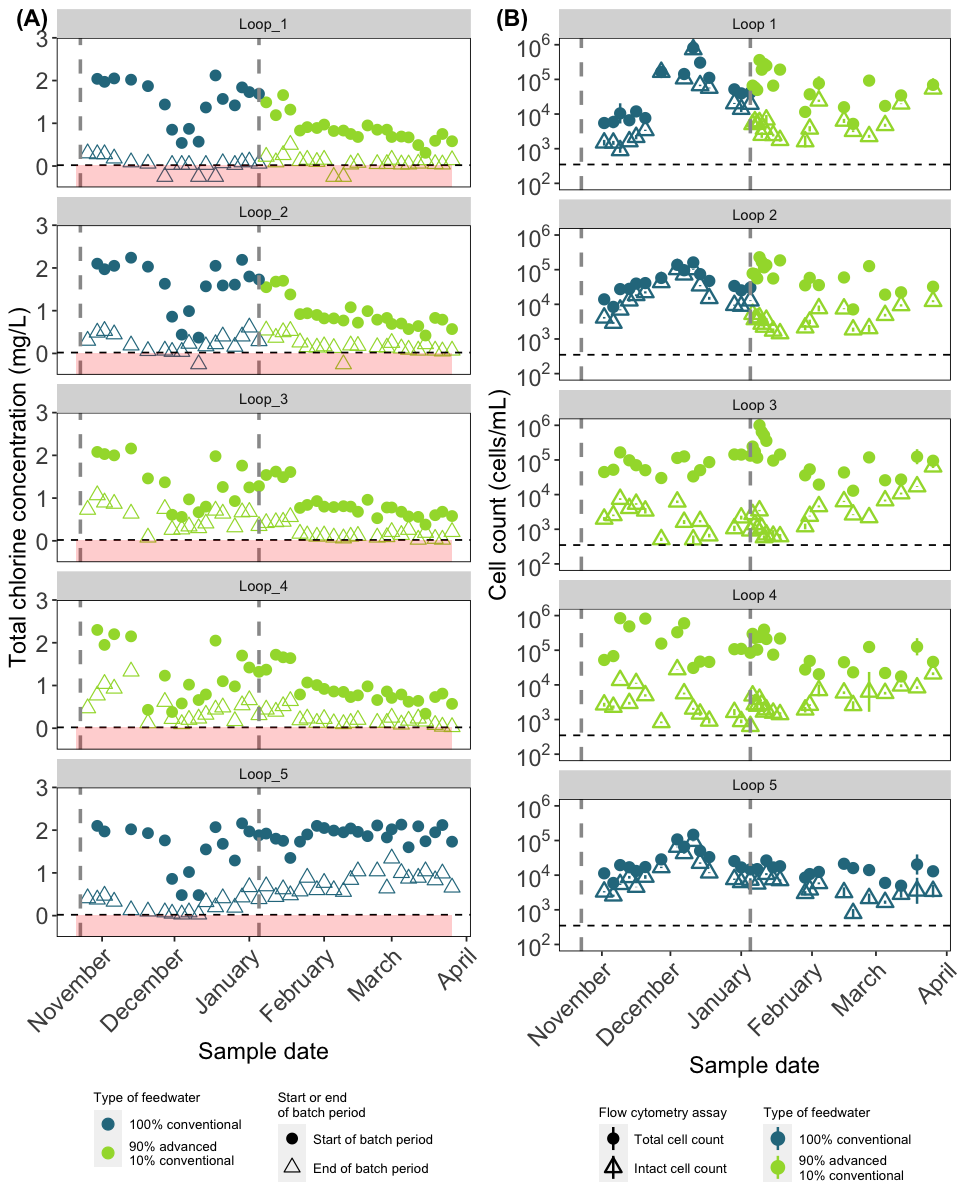

In [28]:
g <- ggarrange(b, a, 
          labels = c("(A)", "(B)"),
          common.legend = FALSE,
          ncol = 2, nrow = 1)

g
ggsave("Figures/Figure_S4.png",  units='mm',device= 'png',width=max_w, height=max_h)


In [29]:
cl_plot$Phase_norm<-cl_plot$Phase
cl_plot[cl_plot$Phase=="Phase 2a","Phase_norm"]<- "Phase 2"
cl_plot[cl_plot$Phase=="Phase 2b","Phase_norm"]<- "Phase 2"
cl_sum<-cl_plot[!is.na(cl_plot$total_Cl2_mg.L),]%>% group_by(location_code, batch_end_or_start, Phase_norm)%>%dplyr::summarize(n=n(), bdl=sum(total_Cl2_mg.L <=0.02), b0.2=sum(total_Cl2_mg.L <=0.2),average=mean(total_Cl2_mg.L))
cl_sum<-cl_sum[cl_sum$batch_end_or_start == "End of batch period",]
cl_sum$P_bdl<-(cl_sum$bdl/cl_sum$n)  *100

cl_sum$P_0.2<-(cl_sum$b0.2/cl_sum$n)  *100


library(stargazer)
cl_sum<-as.data.frame(cl_sum)
cl_sum$location_code<-as.character(cl_sum$location_code)
cl_sum<-cl_sum%>% select(-c(batch_end_or_start, bdl, b0.2))

cl_sum
stargazer(cl_sum,type="html", summary=FALSE, rownames=FALSE, digits=2, out="Figures/Table_S3.doc")


cl_plot$loop_phase<- paste0(cl_plot$location_code, cl_plot$Phase_norm, sep="")
kruskal.test(total_Cl2_mg.L ~ loop_phase, data = cl_plot[!is.na(cl_plot$total_Cl2_mg.L),])
b<-dunn_test(total_Cl2_mg.L ~ loop_phase, data = cl_plot[!is.na(cl_plot$total_Cl2_mg.L),])
b[b$p.adj.signif!= "ns",]

`summarise()` has grouped output by 'location_code', 'batch_end_or_start'. You
can override using the `.groups` argument.

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




location_code,Phase_norm,n,average,P_bdl,P_0.2
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
Loop_1,Phase 1,18,0.09611111,16.666667,83.333333
Loop_1,Phase 2,22,0.11409091,9.090909,86.363636
Loop_2,Phase 1,18,0.25888889,5.555556,44.444444
Loop_2,Phase 2,22,0.20045455,4.545455,68.181818
Loop_3,Phase 1,18,0.55500000,0.000000,5.555556
Loop_3,Phase 2,22,0.18409091,0.000000,68.181818
Loop_4,Phase 1,18,0.49777778,0.000000,22.222222
Loop_4,Phase 2,22,0.21045455,0.000000,63.636364
Loop_5,Phase 1,18,0.26111111,0.000000,50.000000



<table style="text-align:center"><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">location_code</td><td>Phase_norm</td><td>n</td><td>average</td><td>P_bdl</td><td>P_0.2</td></tr>
<tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Loop_1</td><td>Phase 1</td><td>18</td><td>0.10</td><td>16.67</td><td>83.33</td></tr>
<tr><td style="text-align:left">Loop_1</td><td>Phase 2</td><td>22</td><td>0.11</td><td>9.09</td><td>86.36</td></tr>
<tr><td style="text-align:left">Loop_2</td><td>Phase 1</td><td>18</td><td>0.26</td><td>5.56</td><td>44.44</td></tr>
<tr><td style="text-align:left">Loop_2</td><td>Phase 2</td><td>22</td><td>0.20</td><td>4.55</td><td>68.18</td></tr>
<tr><td style="text-align:left">Loop_3</td><td>Phase 1</td><td>18</td><td>0.56</td><td>0</td><td>5.56</td></tr>
<tr><td style="text-align:left">Loop_3</td><td>Phase 2</td><td>22</td><td>0.18</td><td>0</td><td>68.18</td></tr>
<tr><td s


	Kruskal-Wallis rank sum test

data:  total_Cl2_mg.L by loop_phase
Kruskal-Wallis chi-squared = 60.212, df = 9, p-value = 1.22e-09


.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
total_Cl2_mg.L,Loop_1Phase 1,Loop_5Phase 2,35,45,4.696172,2.650818e-06,1.086835e-04,***
total_Cl2_mg.L,Loop_1Phase 2,Loop_3Phase 1,45,35,3.440199,5.812856e-04,2.208885e-02,*
total_Cl2_mg.L,Loop_1Phase 2,Loop_5Phase 2,45,45,6.109132,1.001742e-09,4.507837e-08,****
total_Cl2_mg.L,Loop_2Phase 1,Loop_5Phase 2,35,45,3.477576,5.059690e-04,1.973279e-02,*
total_Cl2_mg.L,Loop_2Phase 2,Loop_5Phase 2,45,45,5.299274,1.162643e-07,4.999363e-06,****
total_Cl2_mg.L,Loop_3Phase 2,Loop_5Phase 2,45,45,5.741680,9.374206e-09,4.124651e-07,****
total_Cl2_mg.L,Loop_4Phase 2,Loop_5Phase 2,45,45,5.225692,1.735053e-07,7.287221e-06,****
total_Cl2_mg.L,Loop_5Phase 1,Loop_5Phase 2,34,45,3.617154,2.978603e-04,1.191441e-02,*
